this notebook tries to replicate what's in <https://github.com/leelabcnbc/tang-paper-2017/blob/master/neuron_fitting_analysis/rtc_on_relevant_filters.ipynb>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os.path
from torchvision.utils import make_grid
from torch import FloatTensor
from scipy.stats import pearsonr
from skimage.io import imsave as imsave_ski
from torch.backends import cudnn
cudnn.enabled = False  # for deterministic.

In [2]:
from strflab import rta, rtc
from numpy.random import RandomState
from torch.autograd import Variable

In [3]:
from tang_jcompneuro import dir_dictionary
from tang_jcompneuro.io import load_split_dataset, split_file_name_gen, load_image_dataset
from tang_jcompneuro.model_fitting_cnn import opt_configs_to_explore, models_to_train, init_config_to_use_fn, train_one_case
from tang_jcompneuro.cnn import CNN
import time

imsave_global_dir = os.path.join(dir_dictionary['plots'], 'supp', 'rtc')
os.makedirs(imsave_global_dir, exist_ok=True)

def imsave(x, y):
    imsave_ski(os.path.join(imsave_global_dir, x), y)

In [4]:
# let's train a model.
# neuron 553, split 0, all stimuli. monkey A.
# let me check what config worked best during training.
# and I will just use that.
#
def load_data():
    datasets_local = load_split_dataset('MkA_Shape', 'all', True, 553)
    return datasets_local

datasets = load_data()

def load_data_idx():
    # get testing index.
    datafile_x = split_file_name_gen(None)
    with h5py.File(datafile_x, 'r') as f_x:
        index_this = f_x[f'/MkA_Shape/all/with_val/100/0/test'].attrs['index']
    return index_this

dataset_test_idx = load_data_idx()
assert dataset_test_idx.shape == (1900,)

def load_trained_model():
    with h5py.File(os.path.join(dir_dictionary['models'], 'cnn', 'b.4',
                                'MkA_Shape', 'all', '100', '0', '550_600.hdf5'), 'r') as f_out:
        grp_this = f_out['/MkA_Shape/all/100/0/cnn/b.4/553']
        best_config, best_corr_ref = grp_this.attrs['best_config'], grp_this['corr'][()]
        
    config_to_use = '1e-3L2_1e-3L2_adam002_mse'
    assert config_to_use == best_config
    
    # ok. l
    opt_config = opt_configs_to_explore[config_to_use]
    arch_config = models_to_train['b.4']
#     print(opt_config, arch_config)
    
    
    model = CNN(arch_config, init_config_to_use_fn(), mean_response=datasets[1].mean(axis=0),
                # change seed if you get unlucky for unstable input...
                # this is the case especially for MkE2_Shape.
                # i think this was an issue before as well.
                # except that pytorch 0.2.0 doesn't report such errors.
                # check /inf_debug_script.py
                # seed=42,
                seed=0,
                # last ditch
                # for some avg_sq
                # scale_hack=0.9,
                # for other avg_sq
                # as well as other models.
                scale_hack=None,
                # for MLP model, use PCAed data.
                input_size=20,
                # scale_hack = 0.0
                )
    
    model.cuda()
    t1 = time.time()
    y_val_cc, y_test_hat, new_cc = train_one_case(model, datasets, opt_config,
                                                  seed=2, show_every=1000,
                                                  return_val_perf=True,
                                                  max_epoch=20000)
    t2 = time.time()
    print(t2-t1, 'sec')
    print('ref corr', best_corr_ref, 'current corr', new_cc)
    return y_test_hat, new_cc, model
    
    
y_test_hat_global, new_cc_global, model_global = load_trained_model()


========starting phase 1/1==========
========starting epoch 1000==========
val metric
 {'neg_corr': -0.50087142, 'corr': 0.50087142, 'mse': 0.0056876359}
test metric
 {'neg_corr': -0.48178706, 'corr': 0.48178706, 'mse': 0.0059664664}
========done epoch 1000==========
========starting epoch 2000==========
val metric
 {'neg_corr': -0.57883465, 'corr': 0.57883465, 'mse': 0.0050870827}
test metric
 {'neg_corr': -0.56199622, 'corr': 0.56199622, 'mse': 0.0054245014}
========done epoch 2000==========
========starting epoch 3000==========
val metric
 {'neg_corr': -0.66509664, 'corr': 0.66509664, 'mse': 0.0043529035}
test metric
 {'neg_corr': -0.63846266, 'corr': 0.63846266, 'mse': 0.0046236636}
========done epoch 3000==========
========starting epoch 4000==========
val metric
 {'neg_corr': -0.65819037, 'corr': 0.65819037, 'mse': 0.0042943177}
test metric
 {'neg_corr': -0.64685243, 'corr': 0.64685243, 'mse': 0.0045310701}
========done epoch 4000==========
========starting epoch 5000==========
v

In [5]:
y_test_hat_global = y_test_hat_global[:,0]

In [6]:
weight_values = None
for x, y in model_global.named_parameters():
    if x == 'conv.conv0.weight':
        weight_values = y.data.cpu().numpy().copy()
        break

In [7]:
def imshow(npimg, figsize=(8, 6), save_name=None):
    plt.close('all')
    plt.figure(figsize=figsize)
    img_to_show = np.transpose(npimg.numpy(), (1, 2, 0))
    plt.imshow(img_to_show)
    
    if save_name is not None:
        imsave(save_name, img_to_show)
    
    plt.show()

In [8]:
weight_values.shape

(4, 1, 9, 9)

/home/yimengzh/miniconda2/envs/tf15/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


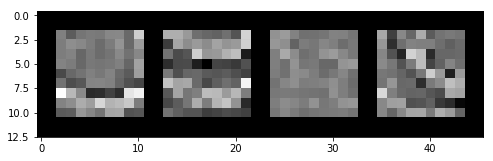

In [9]:
imshow(make_grid(FloatTensor(weight_values),normalize=True, scale_each=False),
       save_name='original_filters.png')

In [10]:
# let's recover it. I think this makes more sense than my previous experiments,
# as here all filters look sensible.

In [11]:
num_stimulus_to_study = (2000, 5000, 10000, 20000, 50000, 100000, 200000,
                         500000,
                        )
model_global.cuda()
model_global.eval()

CNN(
  (conv): Sequential(
    (conv0): Conv2d(1, 4, kernel_size=(9, 9), stride=(1, 1))
    (act0): ReLU()
    (pool0): MaxPool2d(kernel_size=(6, 6), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (fc): Sequential(
    (fc): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [12]:
# double check it can recover the y_recon stored.
# also, I need to show this neuron's tuning curve and the fitting anyway.
X_ref = datasets[2]
y_ref = datasets[3][:,0]

In [13]:
# save top 20 stimuli.
X_ref_big = load_image_dataset('Shape_9500', trans=False)[dataset_test_idx]
print(X_ref_big.shape)

(1900, 1, 40, 40)


In [14]:
y_sort_idx = np.argsort(y_ref)[::-1]
X_ref_big_top = X_ref_big[y_sort_idx[:20]]
X_ref_big_top = make_grid(FloatTensor(X_ref_big_top)[:20], nrow=10, normalize=False, scale_each=False)
X_ref_big_top = np.transpose(X_ref_big_top.numpy(), (1, 2, 0))
print(X_ref_big_top.shape)
imsave('top_20_stimuli.png', X_ref_big_top)

(86, 422, 3)


/home/yimengzh/miniconda2/envs/tf15/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [15]:
y_recon_debug = model_global(Variable(FloatTensor(X_ref).cuda())).data.cpu().numpy()[:,0]

In [16]:
y_recon_debug.shape

(1900,)

In [17]:
pearsonr(y_recon_debug, y_test_hat_global)[0], abs(y_test_hat_global-y_recon_debug).max()

(1.0, 0.0)

In [18]:
assert pearsonr(y_recon_debug, y_ref.astype(np.float32))[0] == new_cc_global

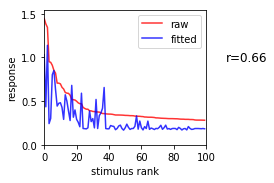

In [19]:
# show tuning curve
def show_tuning_curve(y_original, y_fitted, figsize=(3,2.5), top=None):
    assert y_original.shape == y_fitted.shape == (y_original.size,)
    if top is None:
        top = y_original.size
    plt.close('all')
    fig_this = plt.figure(figsize=figsize)
    sort_idx = np.argsort(y_original)[::-1]
    slice_to_use = slice(top)
    plt.plot(np.arange(top), y_original[sort_idx][slice_to_use], label='raw', color='red', alpha=0.8)
    plt.plot(np.arange(top), y_fitted[sort_idx][slice_to_use], label='fitted', color='blue', alpha=0.8)
    plt.legend()
    plt.xlabel('stimulus rank')
    plt.ylabel('response')
    plt.ylim(0, y_original.max()+0.1)
    plt.xlim(0, top)
    
    r_this = pearsonr(y_original, y_fitted)[0]
    plt.text(x=125,y=1.0,s='r={:.2f}'.format(r_this),
             horizontalalignment='center', verticalalignment='center',fontsize='larger')
    
    fig_this.subplots_adjust(top=0.95, bottom=0.2, left=0.2, right=0.95, hspace=0.1, wspace=0.1)
    fig_this.savefig(os.path.join(imsave_global_dir, 'tuning_curve.pdf'), dpi=300)
    plt.show()
    
show_tuning_curve(y_ref, y_test_hat_global, top=100)

In [20]:
# show top stimuli.

In [21]:
def batch_input(net_this, X, batch_size=1000):
    num_batch = len(X) // batch_size
    assert num_batch*batch_size == len(X)
    
    y_all = []
    for i_batch in range(num_batch):
        start_point = i_batch*batch_size
        end_point = (i_batch+1)*batch_size
        X_this = X[start_point:end_point]
        y_this = net_this(Variable(FloatTensor(X_this).cuda())).data.cpu().numpy()
        y_all.append(y_this)
    return np.concatenate(y_all, axis=0)

In [22]:
def show_rta(rta_this, title, num_iter):
    plt.close('all')
    plt.figure(figsize=(2,2))
#     rta_this_for_show = rta_this/abs(rta_this).max()
    
    grid_image = make_grid(FloatTensor(rta_this.reshape(1, 1, 20, 20)), nrow=1, normalize=True, scale_each=True)
    grid_image = np.transpose(grid_image.numpy(), (1, 2, 0))
    plt.imshow(grid_image)
    plt.title('{} min {:.2f} max {:.2f}'.format(title, rta_this.min(), rta_this.max()))
    
    imsave(f'rta_{num_iter}.png', grid_image)
    
    plt.show()

In [23]:
def show_rtc(vector_original_list, eig_list, title, num_iter, eigenvalue_band=None):
    assert eig_list.shape == (1, eig_list.size)
    plt.close('all')
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle(title)
    axes[0].plot(np.arange(eig_list.size)+1, eig_list[0], label='raw')
    axes[0].set_title('eigen values')
    if eigenvalue_band is not None:
        assert eigenvalue_band.shape == (2, 1, 400)
        eigenvalue_band = eigenvalue_band[:, 0]
        # these two colors shouldn't be the default one...
        axes[0].plot(np.arange(eig_list.size)+1, eigenvalue_band[0], label='lower')
        axes[0].plot(np.arange(eig_list.size)+1, eigenvalue_band[1], label='upper')
        axes[0].set_title('eigen values with 95% CI')
        axes[0].legend(loc='best')
    axes[0].set_xlim(0, 100)
    # for second one, let's just show all filters.
    grid_image = make_grid(FloatTensor(vector_original_list[0].reshape(400, 1, 20, 20))[:10], nrow=10, normalize=True, scale_each=True)
    grid_image = np.transpose(grid_image.numpy(), (1, 2, 0))
    axes[1].imshow(grid_image)
    axes[1].set_title('large eig directions. row major order')
    imsave(f'rtc_top_{num_iter}.png', grid_image)
    
    grid_image = make_grid(FloatTensor(vector_original_list[0].reshape(400, 1, 20, 20))[-10:], nrow=10, normalize=True, scale_each=True)
    grid_image = np.transpose(grid_image.numpy(), (1, 2, 0))
    axes[2].imshow(grid_image)
    axes[2].set_title('small eig directions. row major order')
    imsave(f'rtc_bottom_{num_iter}.png', grid_image)
    plt.show()

(2000, 1, 20, 20) (2000, 1) 65.309 8.73878


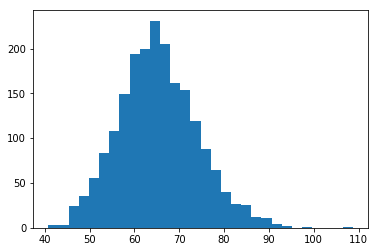

/home/yimengzh/miniconda2/envs/tf15/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


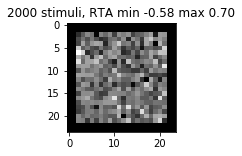

(1, 400, 400) (1, 400)


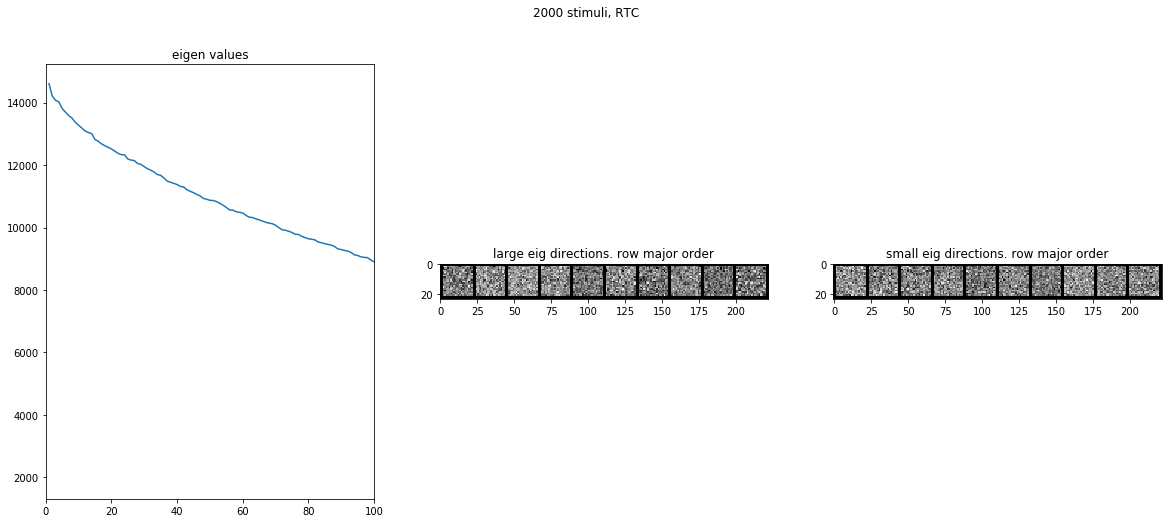

(5000, 1, 20, 20) (5000, 1) 65.2083 8.7786


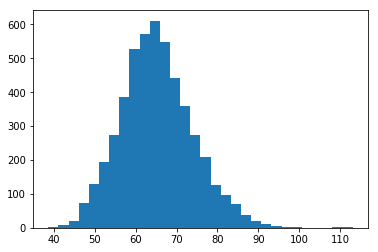

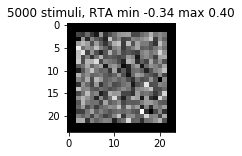

(1, 400, 400) (1, 400)


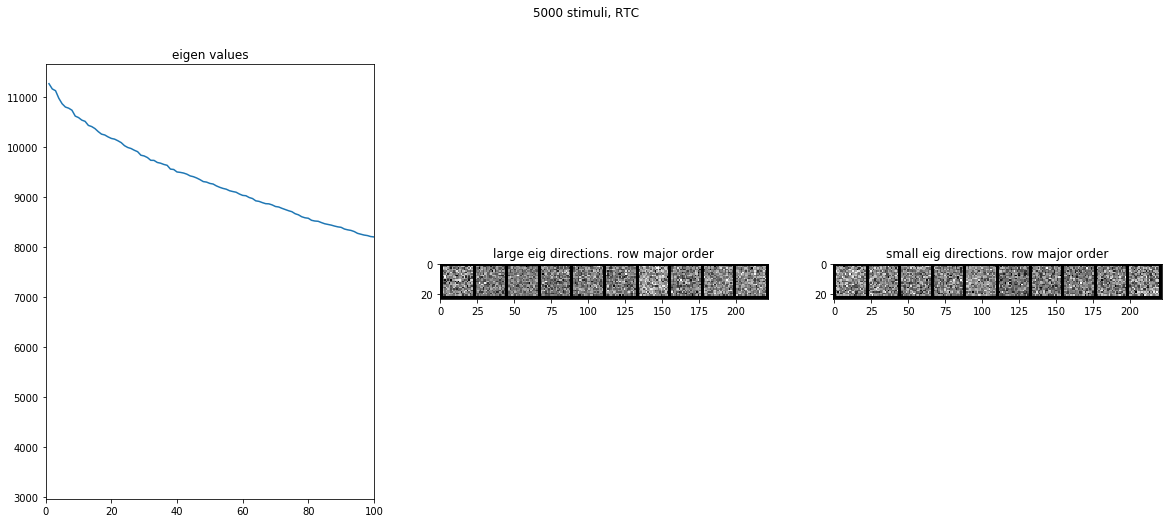

(10000, 1, 20, 20) (10000, 1) 65.3028 8.85291


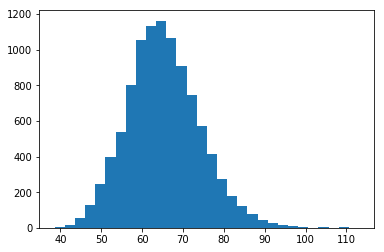

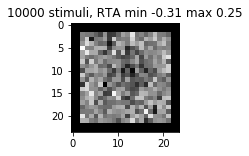

(1, 400, 400) (1, 400)


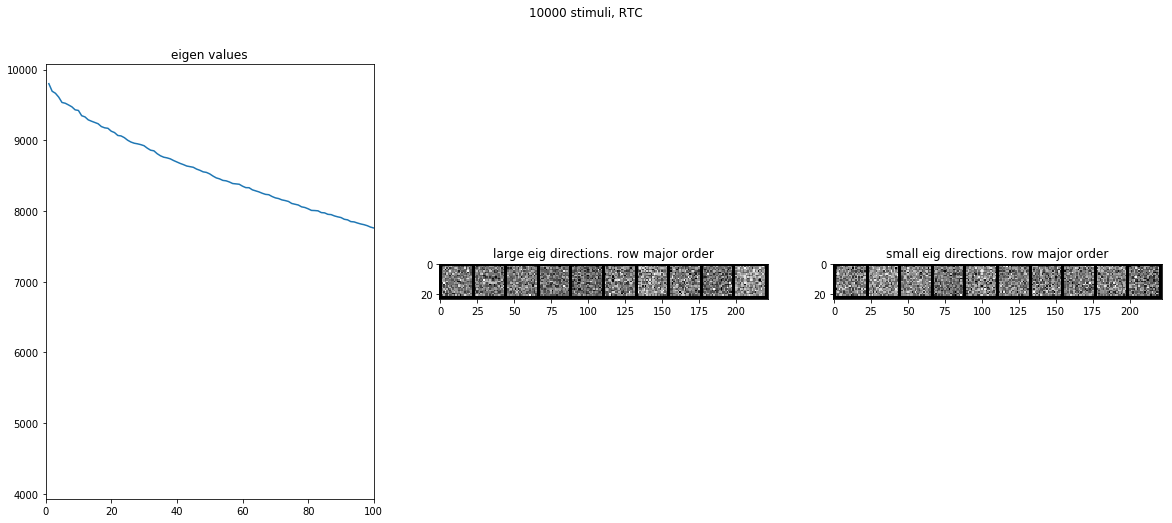

(20000, 1, 20, 20) (20000, 1) 65.2974 8.81311


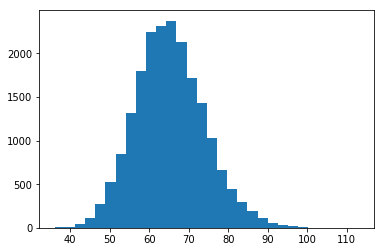

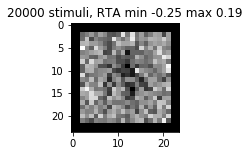

(1, 400, 400) (1, 400)


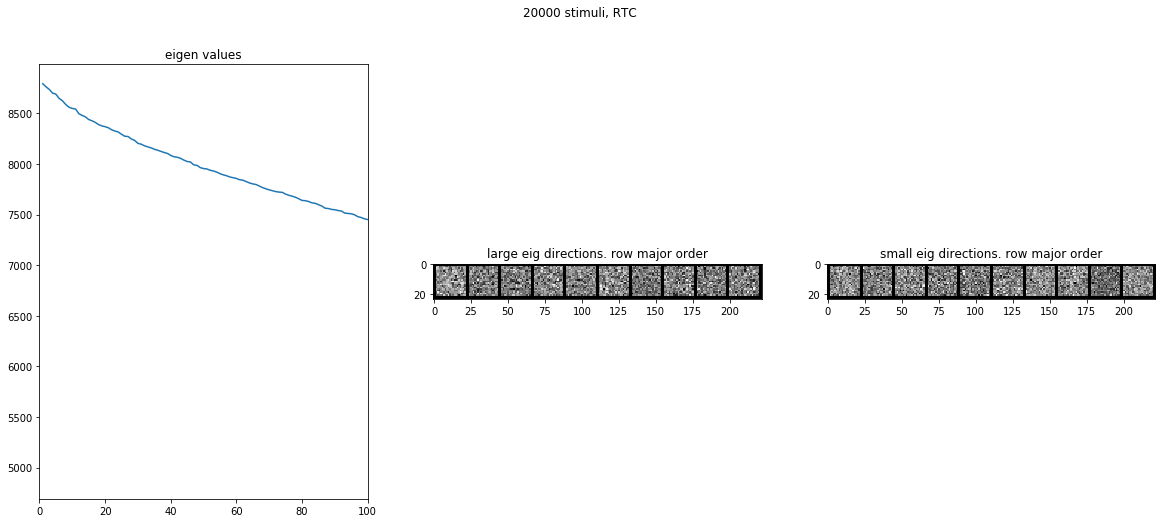

(50000, 1, 20, 20) (50000, 1) 65.2981 8.78561


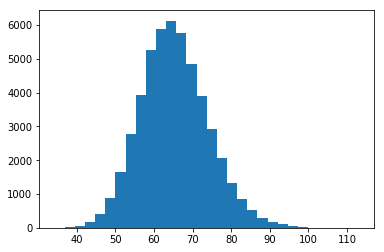

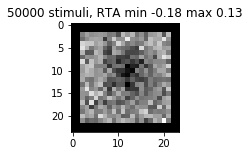

(1, 400, 400) (1, 400)


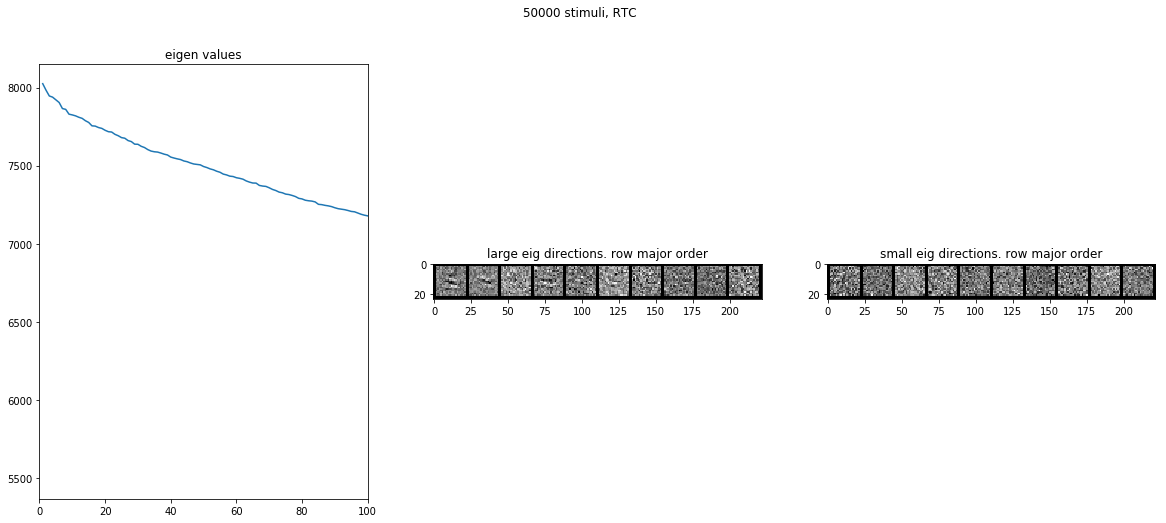

(100000, 1, 20, 20) (100000, 1) 65.3128 8.79782


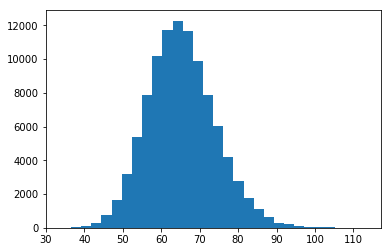

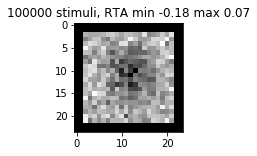

(1, 400, 400) (1, 400)


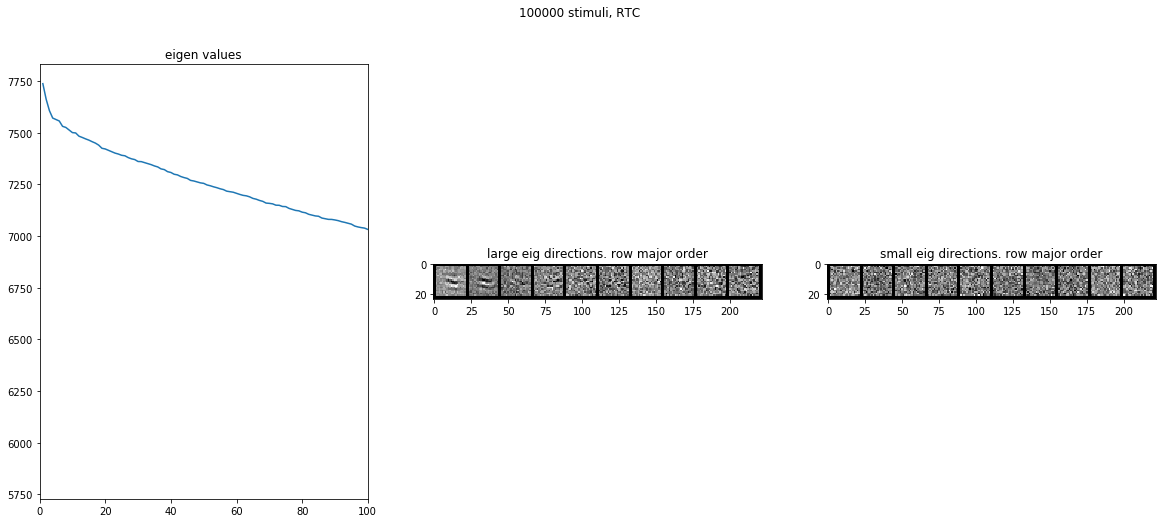

(200000, 1, 20, 20) (200000, 1) 65.3186 8.78806


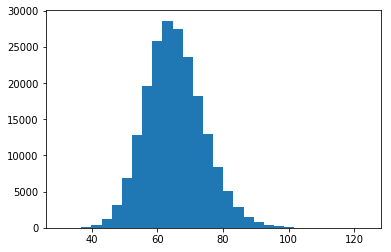

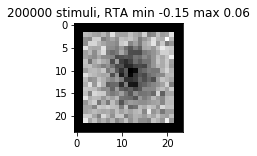

(1, 400, 400) (1, 400)


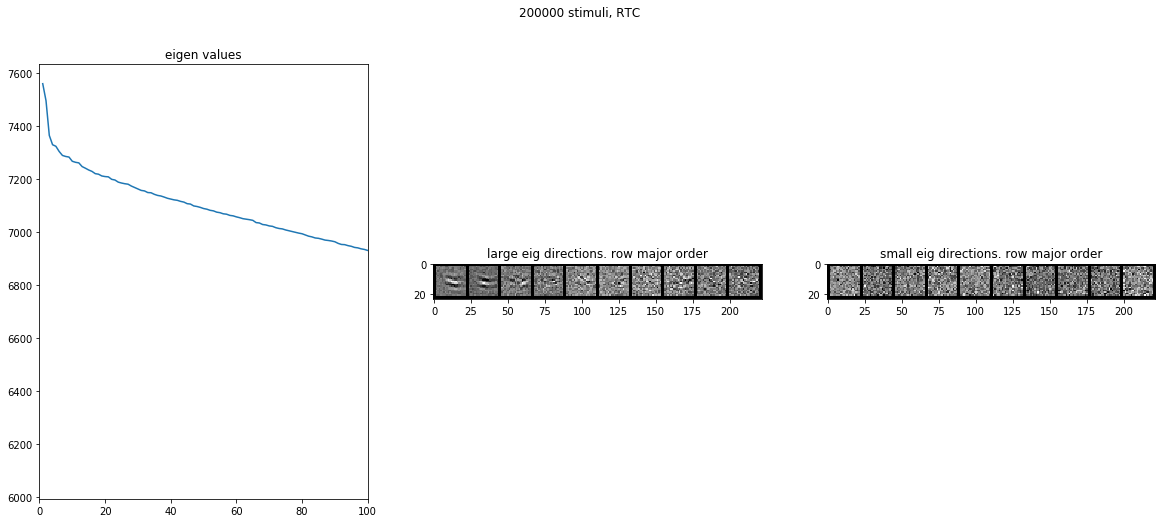

(500000, 1, 20, 20) (500000, 1) 65.3439 8.78163


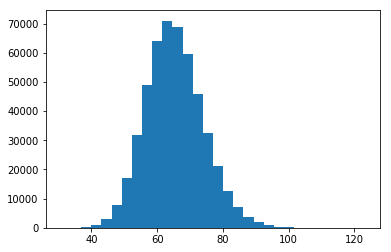

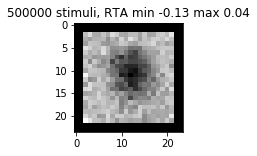

(1, 400, 400) (1, 400)


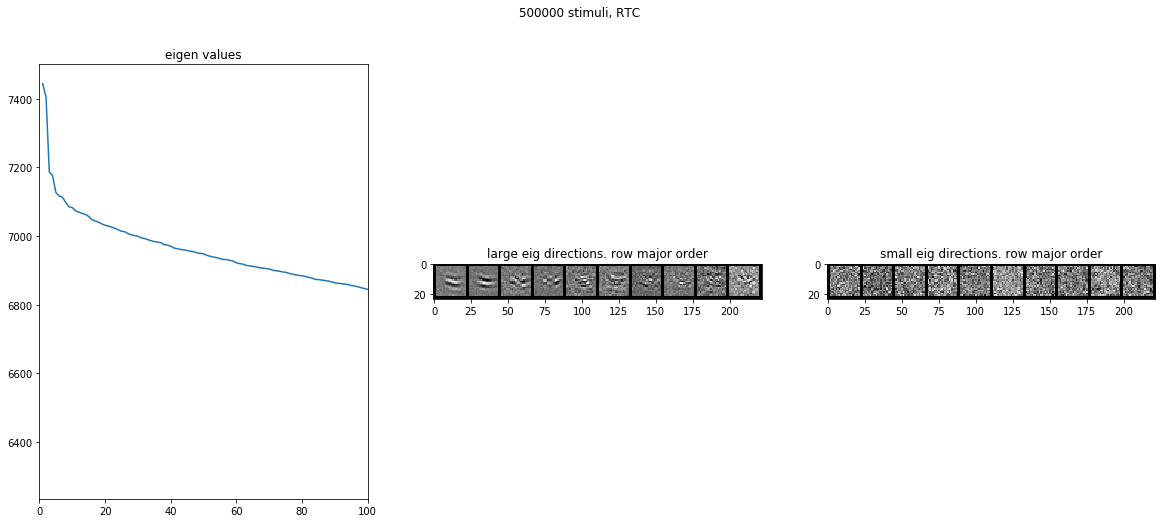

In [24]:
for num_stimulus in num_stimulus_to_study:
    # first, generate stimulus.
    rng_state = RandomState(seed=0)
    # I will just use standard Gaussian, as this seems to drive neurons well enough, by checking the histogram.
    X = 10*rng_state.randn(num_stimulus, 1, 20, 20)

    y_all = batch_input(model_global, X)
    print(X.shape, y_all.shape, y_all.mean(), y_all.std())
    plt.close('all')
    plt.hist(y_all.ravel(), bins=30)
    plt.show()

    # ok. let's first do RTA.
    rta_this = rta.rta(X.reshape(num_stimulus, -1), y_all)
    rta_this = rta_this.reshape(20, 20)
    # show rta, normalized
    show_rta(rta_this, title=f'{num_stimulus} stimuli, RTA', num_iter=num_stimulus)

    vector_original_list, eig_list, *_  = rtc.rtc(X.reshape(num_stimulus, -1), y_all)
    print(vector_original_list.shape, eig_list.shape)

    # go cheap. only 200 trials.
    # 1. still expensive even for 200 trials.
    # 2. not that useful. results show that nearly all eigenvalues are above upper bound CI.
#                     eigenvalue_band = determine_eigenvalue_bands(X.reshape(num_stimulus, -1), y_all, trials=200)
#                     print(eigenvalue_band.shape)
    show_rtc(vector_original_list, eig_list, title=f'{num_stimulus} stimuli, RTC',
             eigenvalue_band=None,num_iter=num_stimulus)